<a href="https://colab.research.google.com/github/divsal009/div/blob/master/Resubmit_tumor_classification_with_ML_CLASSIFIERS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install natsort
from natsort import natsorted, ns
import h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import os
import shutil
import glob
import json
import pickle
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import scipy
from PIL import Image
import skimage.io as io
from skimage.transform import resize

from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, cross_validate
from sklearn.utils import shuffle

from sklearn.utils import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier


import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img, ImageDataGenerator, save_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential, Model, load_model, model_from_json
from tensorflow.keras.layers import (Input, Rescaling, Resizing, InputLayer, Conv2D, MaxPooling2D, Dense, BatchNormalization, Dropout, Activation, GlobalAveragePooling2D, InputSpec, Flatten, Concatenate)
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.metrics import Accuracy, AUC, Precision, Recall
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import warnings
warnings.filterwarnings("ignore")

In [5]:
pip install --upgrade scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.efficientnet import EfficientNetB5

In [7]:
!pip install tensorflow_addons
import tensorflow_addons as tfa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
pd.set_option('display.max_colwidth' , 200)

In [9]:
import os
import PIL
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import h5py
import cv2
from google.colab.patches import cv2_imshow
%matplotlib inline

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
if not os.path.exists('/content/drive/My Drive/Colab Notebooks/dataset1'):
  os.mkdir('/content/drive/My Drive/Colab Notebooks/dataset1')

In [13]:
with zipfile.ZipFile('/content/drive/My Drive/Colab Notebooks/dataset1/data.zip') as zf:
  zip_dir = zf.namelist()[0]
  zf.extractall('/content/drive/My Drive/Colab Notebooks/dataset1')

In [14]:
with zipfile.ZipFile('/content/drive/My Drive/Colab Notebooks/dataset1/brainTumorDataPublic_1-766.zip') as zf:
  os.mkdir('/content/drive/My Drive/Colab Notebooks/dataset1/bt_set1')
  zip_dir = zf.namelist()[0]
  zf.extractall('/content/drive/My Drive/Colab Notebooks/dataset1/bt_set1')

In [15]:
with zipfile.ZipFile('/content/drive/My Drive/Colab Notebooks/dataset1/brainTumorDataPublic_767-1532.zip') as zf:
  os.mkdir('/content/drive/My Drive/Colab Notebooks/dataset1/bt_set2')
  zip_dir = zf.namelist()[0]
  zf.extractall('/content/drive/My Drive/Colab Notebooks/dataset1/bt_set2')

In [16]:
with zipfile.ZipFile('/content/drive/My Drive/Colab Notebooks/dataset1/brainTumorDataPublic_1533-2298.zip') as zf:
  os.mkdir('/content/drive/My Drive/Colab Notebooks/dataset1/bt_set3')
  zip_dir = zf.namelist()[0]
  zf.extractall('/content/drive/My Drive/Colab Notebooks/dataset1/bt_set3')

In [17]:
with zipfile.ZipFile('/content/drive/My Drive/Colab Notebooks/dataset1/brainTumorDataPublic_2299-3064.zip') as zf:
  os.mkdir('/content/drive/My Drive/Colab Notebooks/dataset1/bt_set4')
  zip_dir = zf.namelist()[0]
  zf.extractall('/content/drive/My Drive/Colab Notebooks/dataset1/bt_set4')

In [18]:
os.mkdir('/content/drive/My Drive/Colab Notebooks/dataset1/imageData')

In [19]:
!mv /content/drive/'My Drive'/'Colab Notebooks'/dataset1/bt_set1/*.mat '/content/drive/My Drive/Colab Notebooks/dataset1/imageData/'
!mv /content/drive/'My Drive'/'Colab Notebooks'/dataset1/bt_set2/*.mat '/content/drive/My Drive/Colab Notebooks/dataset1/imageData/'
!mv /content/drive/'My Drive'/'Colab Notebooks'/dataset1/bt_set3/*.mat '/content/drive/My Drive/Colab Notebooks/dataset1/imageData/'
!mv /content/drive/'My Drive'/'Colab Notebooks'/dataset1/bt_set4/*.mat '/content/drive/My Drive/Colab Notebooks/dataset1/imageData/'

In [20]:
mypath = "../content/drive/My Drive/Colab Notebooks/dataset1/imageData"
fileslist = natsorted([f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))])

In [21]:
fileslist[:10]

['1.mat',
 '2.mat',
 '3.mat',
 '4.mat',
 '5.mat',
 '6.mat',
 '7.mat',
 '8.mat',
 '9.mat',
 '10.mat']

['PID', 'image', 'label', 'tumorBorder', 'tumorMask']
(512, 512) (1, 1)


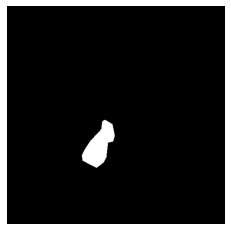

In [22]:
path = "../content/drive/My Drive/Colab Notebooks/dataset1/imageData/"
f = h5py.File(path + fileslist[0], 'r')
print(list(f['cjdata'].keys()))

data = f.get('cjdata/tumorMask/')
label = f.get('cjdata/label/')
data = np.array(data)
label = np.array(label)

print(data.shape , label.shape)

plt.imshow(data, cmap = 'gray')
plt.axis(False);

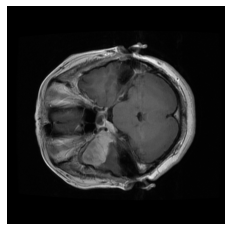

In [23]:
sample = f.get('cjdata/image/')
sample = np.array(sample)
plt.imshow(sample, cmap = 'gray')
plt.axis(False);

In [24]:
# BATCH_SIZE = 32
# NUM_EPOCHS = 75
# IMG_SIZE = 100
# INPUT_SHAPE = (100, 100, 3)

BATCH_SIZE = 32
NUM_EPOCHS = 75
IMG_SIZE = 256
INPUT_SHAPE = (512,512,3)

In [25]:
x_data = np.zeros((len(os.listdir(path)), IMG_SIZE, IMG_SIZE, 3))
y_data = []

mean_val = []
std_val = []
max_val = []
min_val = []
skew_val = []
kurt_val = []
entropy_val = []


for idx in range(len(os.listdir(path))):
    f = h5py.File(path + fileslist[idx],'r')

    data = f.get('cjdata/image/')
    label = f.get('cjdata/label/')
    data = np.array(data)
    label = np.array(label, dtype='int')
    f.close()
    im = Image.fromarray(data).convert("RGB").resize((IMG_SIZE, IMG_SIZE))
    im = np.asarray(im, dtype='float32')
    x_data[idx] = im
    y_data.append(label[0][0])
    
    mean_val.append(im.mean())
    std_val.append(im.std())
    max_val.append(im.max())
    min_val.append(im.min())
    skew_val.append(scipy.stats.skew(im.flatten()))
    kurt_val.append(scipy.stats.kurtosis(im.flatten()))
    entropy_val.append(scipy.stats.entropy(im.flatten()))

In [26]:
np.unique(y_data, return_counts=True)

(array([1, 2, 3]), array([ 708, 1426,  930]))

In [27]:
y = np.array(y_data)
y.shape

(3064,)

In [28]:
y

array([1, 1, 1, ..., 2, 1, 1])

In [29]:
y[y == 1] = 0

In [30]:
y[y == 2] = 1

In [31]:
y[y == 3] = 2

In [32]:
data = pd.DataFrame(list(zip(mean_val, std_val, skew_val, kurt_val, entropy_val)))
data.columns = ['mean_val', 'std_val', 'skew_val', 'kurt_val', 'entropy_val']
data.sample(10 , random_state = SEED)

,mean_val,std_val,skew_val,kurt_val,entropy_val
1241,157.001404,94.106644,-0.429650,-1.450014,11.958207
203,115.448975,113.194702,0.340547,-1.758148,11.620768
1260,199.152512,91.102303,-1.142222,-0.544276,12.044051
1626,186.384521,97.479431,-0.847949,-1.077242,11.995905
1578,192.910767,91.093353,-1.034977,-0.544180,12.025488
102,130.339310,115.396324,0.066043,-1.868261,11.683544
2925,129.832031,101.125504,0.347105,-1.760610,11.869749
1582,188.901352,94.990166,-0.899181,-0.920563,12.008367
485,140.995407,108.224609,-0.180953,-1.786086,11.810524
1437,137.993271,116.364815,-0.070205,-1.885779,11.714902


In [33]:
X = data.iloc[:, :].values
X.shape

(3064, 5)

In [34]:
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3, stratify=y_data)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((2144, 5), (920, 5), (2144,), (920,))

In [35]:
y_test

array([1, 2, 1, 1, 0, 1, 0, 2, 1, 2, 2, 1, 1, 0, 2, 1, 2, 2, 1, 1, 2, 1,
       2, 2, 2, 2, 1, 0, 2, 2, 2, 1, 1, 1, 1, 0, 2, 1, 2, 1, 1, 1, 2, 0,
       1, 2, 2, 2, 2, 1, 1, 2, 0, 1, 2, 0, 1, 1, 0, 0, 2, 2, 2, 1, 1, 0,
       2, 1, 1, 0, 2, 1, 2, 0, 0, 1, 2, 0, 2, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       2, 2, 1, 2, 1, 1, 0, 1, 1, 0, 2, 2, 0, 0, 1, 0, 0, 0, 0, 2, 0, 1,
       1, 0, 2, 1, 0, 2, 1, 0, 1, 0, 2, 0, 1, 2, 2, 1, 2, 2, 0, 1, 1, 0,
       2, 2, 1, 1, 2, 1, 1, 2, 0, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 2, 1,
       2, 1, 2, 1, 1, 1, 0, 2, 1, 1, 0, 1, 1, 1, 2, 0, 1, 1, 2, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 2, 2, 2, 2, 0, 0, 1, 2, 1, 1, 1, 2, 1, 0, 1, 0,
       1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 0, 1, 0, 1, 2, 0, 2, 1, 1, 1, 1, 0,
       1, 0, 2, 0, 1, 2, 2, 0, 1, 2, 1, 0, 0, 2, 1, 2, 1, 0, 2, 2, 1, 0,
       0, 2, 1, 2, 2, 1, 1, 2, 0, 1, 1, 2, 1, 2, 1, 1, 0, 0, 2, 1, 1, 1,
       2, 1, 2, 1, 0, 2, 0, 1, 0, 1, 2, 1, 1, 1, 0, 0, 2, 0, 1, 0, 0, 1,
       1, 0, 0, 2, 1, 1, 2, 0, 1, 2, 1, 0, 2, 1, 1,

In [58]:
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score, f1_score, recall_score, precision_score,
                             auc, roc_curve, roc_auc_score, cohen_kappa_score)

## SVM

In [59]:
def SVMModel(X, Y, x, y):
    # constants
    n_iter_search = 10
    param_dist = {
        'C': [1, 10, 100, 1000, 10000],
        'gamma': [0.0001, 0.001, 0.01, 0.1, 1],
    }
    
    print(X.shape, Y.shape)
    print(x.shape, y.shape)
    
    # random search
    estimator = SVC(kernel='rbf', decision_function_shape='ovo')
    random_search = RandomizedSearchCV(estimator = estimator,
                                       param_distributions = param_dist,
                                       n_iter = n_iter_search,
                                       n_jobs = -1,
                                       refit = True,
                                       cv = 3,
                                       verbose = 2
                                      )
    random_search.fit(X, Y)
    bp = random_search.best_params_

    # model fit
    svc = SVC(C = bp['C'], kernel = 'rbf', gamma = bp['gamma'], decision_function_shape = "ovo")
    svc.fit(X, Y)
    
    # prediction
    preds = svc.predict(x)
    print(classification_report(y, preds))


In [60]:
SVMModel(x_train, y_train, x_test, y_test)

(2144, 5) (2144,)
(920, 5) (920,)
Fitting 3 folds for each of 10 candidates, totalling 30 fits
              precision    recall  f1-score   support

           0       0.63      0.62      0.62       213
           1       0.82      0.81      0.81       428
           2       0.86      0.90      0.88       279

    accuracy                           0.79       920
   macro avg       0.77      0.77      0.77       920
weighted avg       0.79      0.79      0.79       920



## RandomForest

In [61]:
def RandomForestModel(X, Y, x, y):
    # constants
    n_iter_search = 10
    param_dist = {
        'max_depth': [10, 20, 30, 40],
        'min_samples_leaf': [2, 4, 5],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400]
    }
    
    print(X.shape, Y.shape)
    print(x.shape, y.shape)
    
    estimator = RandomForestClassifier()
    random_search = RandomizedSearchCV(estimator = estimator,
                                       param_distributions = param_dist,
                                       n_iter = n_iter_search,
                                       n_jobs = -1,
                                       refit = True,
                                       cv = 2,
                                       verbose = 2
                                      )
    random_search.fit(X, Y)
    bp = random_search.best_params_

    # model fit
    rfc = RandomForestClassifier(bootstrap=True, criterion='gini', max_depth=bp['max_depth'], max_features='auto', min_samples_leaf=bp['min_samples_leaf'],
                           min_samples_split=bp['min_samples_split'], n_estimators=bp['n_estimators'], n_jobs=-1, random_state=42, verbose=0)
    rfc.fit(X, Y)
    
    # prediction
    preds = rfc.predict(x)
    print(classification_report(y, preds))

In [62]:
RandomForestModel(x_train, y_train, x_test, y_test)

(2144, 5) (2144,)
(920, 5) (920,)
Fitting 2 folds for each of 10 candidates, totalling 20 fits
              precision    recall  f1-score   support

           0       0.63      0.58      0.60       213
           1       0.82      0.80      0.81       428
           2       0.85      0.92      0.89       279

    accuracy                           0.79       920
   macro avg       0.77      0.77      0.77       920
weighted avg       0.78      0.79      0.79       920



## NAIVE BAYES

In [63]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(x_train, y_train)

GaussianNB()

In [64]:
Y_pred = classifier.predict(x_test)

In [65]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, Y_pred)

In [66]:
 print(classification_report(y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.49      0.10      0.17       213
           1       0.56      0.80      0.66       428
           2       0.68      0.66      0.67       279

    accuracy                           0.59       920
   macro avg       0.58      0.52      0.50       920
weighted avg       0.58      0.59      0.55       920



## DECISION TREE

In [67]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [68]:
Y_pred = classifier.predict(x_test)


In [69]:
 print(classification_report(y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.57      0.56      0.56       213
           1       0.77      0.76      0.77       428
           2       0.81      0.84      0.83       279

    accuracy                           0.74       920
   macro avg       0.72      0.72      0.72       920
weighted avg       0.74      0.74      0.74       920



REF 
https://towardsdatascience.com/building-a-simple-machine-learning-model-on-breast-cancer-data-eca4b3b99fa3